# Retention Scoring
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

In [1]:
import boto3
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pycaret.classification import *

In [2]:
if not boto3.DEFAULT_SESSION:
    ! aws sso login --profile US-StellarSupport
    session = boto3.setup_default_session(profile_name='US-StellarSupport')

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

LGLR-TXQJ
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [3]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [4]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [mlsInterMiami].[ds].[getRetentionScoringModelData] 113 """
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(6942, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6942 entries, 0 to 6941
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6942 non-null   int64  
 1   year                 6942 non-null   int64  
 2   productGrouping      6942 non-null   object 
 3   email                6926 non-null   object 
 4   ticketingid          6942 non-null   object 
 5   totalSpent           6942 non-null   float64
 6   recentDate           6942 non-null   object 
 7   attendancePercent    6942 non-null   float64
 8   renewedBeforeDays    6942 non-null   int64  
 9   source_tenure        6942 non-null   int64  
 10  tenure               6942 non-null   int64  
 11  distToVenue          6787 non-null   float64
 12  recency              6942 non-null   int64  
 13  missed_games_1       6942 non-null   int64  
 14  missed_games_2       6942 non-null   int64  
 15  missed_games_over_2  6942 non-null   i

### We should specify the features used in our model:

In [6]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "ticketingid",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2022]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3599, 17)
Unseen Data For Predictions: (635, 17)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [7]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=[
        "dimCustomerMasterId",
        "email",
        "productGrouping",
        "ticketingid",
        "year"
    ],
    numeric_features=[
        "attendancePercent", 
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalSpent" 
    ]
);

In [8]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7215,0.8229,0.6671,0.7450,0.7036,0.4424,0.4452,1.0440


In [9]:
lightgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7418,0.8373,0.7105,0.7552,0.7322,0.4834,0.4843
1,0.7059,0.8092,0.6711,0.7183,0.6939,0.4115,0.4124
2,0.7026,0.8135,0.6316,0.7328,0.6784,0.4047,0.4085
3,0.7288,0.8301,0.6645,0.7594,0.7088,0.4571,0.4606
4,0.7320,0.8116,0.6513,0.7734,0.7071,0.4635,0.4693
5,0.6863,0.7933,0.6118,0.7154,0.6596,0.3719,0.3758
6,0.7288,0.8360,0.7039,0.7379,0.7205,0.4573,0.4578
7,0.7288,0.8186,0.6887,0.7429,0.7148,0.4569,0.4581
8,0.7418,0.8414,0.6689,0.7769,0.7189,0.4826,0.4873


### Let's load in our 2021 season data and get retention scores using the model:

In [10]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2708, 17)

In [11]:
lightgbm_predictions = predict_model(lightgbm_model, data=df_inference, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6400,0,0.0000,0.0000,0.0000,0.0000,0.0000


In [12]:
print(f"lightgbm:\n {lightgbm_predictions.Label.value_counts()}")

lightgbm:
 0    1733
1     975
Name: Label, dtype: int64


In [13]:
print(f"lightgbm:\n {lightgbm_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")

lightgbm:
 (-0.001, 0.25]    972
(0.25, 0.5]       761
(0.5, 0.75]       559
(0.75, 1.0]       416
Name: Score_1, dtype: int64


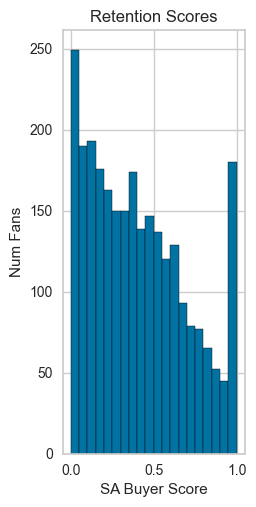

In [14]:
model_predictions = [lightgbm_predictions]

for idx, df_predictions in enumerate(model_predictions):

    plt.subplot(1, 3, idx+1)

    plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black')
    plt.title("Retention Scores")
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

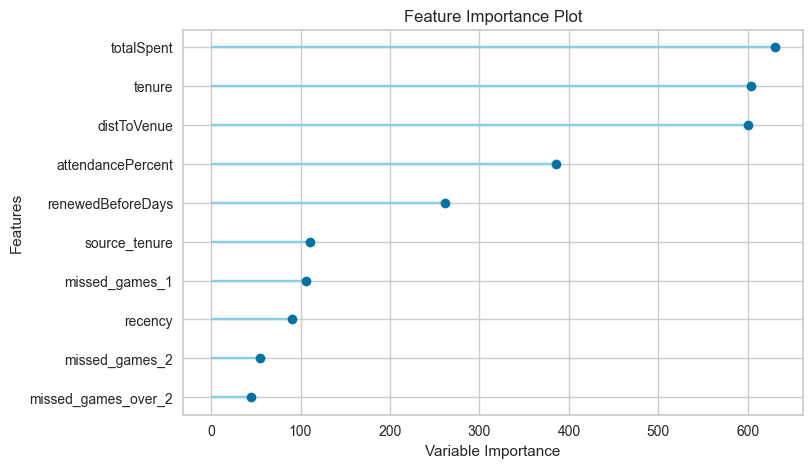

In [15]:
plot_model(lightgbm_model, plot='feature')

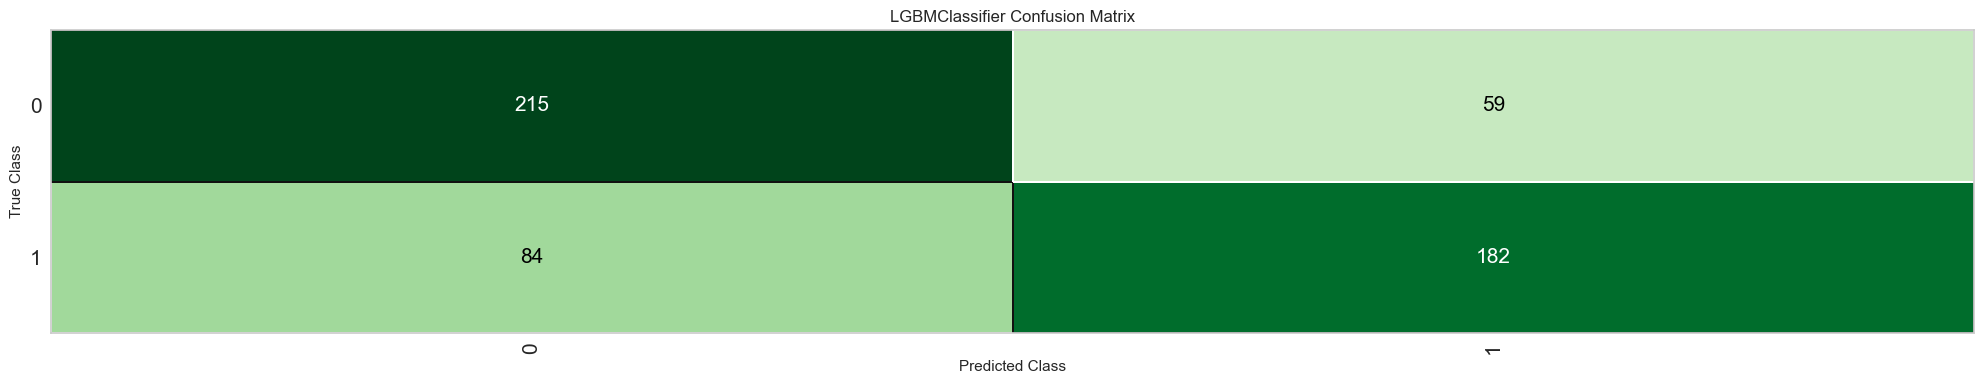

In [16]:
plot_model(lightgbm_model, plot='confusion_matrix')

In [17]:
lightgbm_predictions

,dimCustomerMasterId,year,productGrouping,email,ticketingid,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
2,52,2022,Full Season,06guer1103@gmail.com,253859,1985.81,2022-10-09,1.00,96,730,746,17.84,0,0,0,0,0,1,0.3342,0.6658
5,179,2022,Flex Plan,195cleanup@gmail.com,270764,312.00,2022-07-13,0.88,9,730,150,38.20,0,0,0,0,0,0,0.9871,0.0129
9,466,2022,Full Season,4jcmas@gmail.com,232105,12836.14,2022-10-05,0.60,162,730,949,48.37,0,2,1,0,0,1,0.4426,0.5574
12,530,2022,Full Season,6xiirt@gmail.com,277117,875.50,2022-10-05,0.63,159,44530,758,57.52,0,3,1,0,0,1,0.0303,0.9697
15,632,2022,Full Season,9espi9@gmail.com,295807,439.84,1970-01-01,0.00,162,730,752,47.79,0,0,0,1,0,0,0.9796,0.0204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6919,990211,2022,Flex Plan,zegman.88@gmail.com,259397,471.00,2022-07-13,1.00,9,730,27,50.84,0,0,0,0,0,0,0.9990,0.0010
6935,11686478,2022,Full Season,xmikerurx@gmail.com,150931,5065.65,2022-10-09,0.80,162,1095,1054,59.73,0,0,0,0,0,0,0.5408,0.4592
6936,11919301,2022,Flex Plan,bocelli71@aol.com,1559117,146.00,2022-10-05,1.00,36,0,36,22.40,0,0,0,0,0,0,0.9905,0.0095
6938,11999374,2022,Full Season,mattmueller2030@gmail.com,300749,1575.90,2022-10-09,0.63,80,44530,913,30.30,0,5,0,0,0,1,0.0066,0.9934


In [18]:
current_date = datetime.today().strftime('%Y-%m-%d')

In [19]:
df_output = pd.DataFrame()
df_output["attendancepercentage"] = lightgbm_predictions["attendancePercent"]
df_output["clientcode"] = "mlsintermiami"
df_output["dimcustomermasterid"] = lightgbm_predictions["dimCustomerMasterId"]
df_output["email"]= lightgbm_predictions["email"]
df_output["lkupclientid"] = 113
df_output["mostrecentattendance"] = lightgbm_predictions["recentDate"]
df_output["product"] = lightgbm_predictions["productGrouping"]
df_output["sascore"] = lightgbm_predictions["Score_1"]
df_output["scoredate"] = current_date
df_output["seasonyear"] = lightgbm_predictions["year"]
df_output["tenuredays"] = lightgbm_predictions["tenure"]
df_output["ticketingid"] = lightgbm_predictions["ticketingid"]

In [21]:
s3 = boto3.resource('s3')

bucket = "us-curated-data-sci-retention-us-east-1-5h6cml"
current_date = datetime.today().strftime('%Y-%m-%d')
path = "./data/retention-scores.csv"

df_output.to_csv(path, index=False)
s3.Bucket(bucket).upload_file(path, f'date={current_date}/mlsintermiami/scores.csv')

### Done